# Start of analysis

Calculate whether each geocode is a net loser or gainer of employment.

If loser: 

- Categories lost in m2 and units

If gainer:

- Categories required in m2 and units

First get winners/losers, then calculate ratio of employment

In [1]:
import pandas as pd
from IPython.display import clear_output, display

In [15]:
import pandas as pd
from IPython.display import clear_output, display
#from tqdm import tqdm
#https://stackoverflow.com/questions/42855972/printing-on-the-same-line-on-a-jupyter-notebook

dfe = pd.read_csv("C:/Users/Turukawa/OneDrive/Whythawk/Projects/Pikhaya/Custom_draws/employment_by_place_of_residence.csv")
dfs = pd.read_csv("C:/Users/Turukawa/OneDrive/Whythawk/Projects/Pikhaya/Custom_draws/report_summary.csv")
dfa = pd.read_csv("C:/Users/Turukawa/OneDrive/Whythawk/Projects/Pikhaya/Custom_draws/report_summary_all_quarters.csv")

In [16]:
# Get the difference
geocodes = dfs["geocode"].unique()
#dfe = dfe[pd.notnull(dfe["work"]) & pd.notnull(dfe["residence"]) & dfe["geocode"].isin(geocodes)]
dfe = dfe[dfe["geocode"].isin(geocodes)]
dfe["change"] = dfe["residence"] - dfe["work"]
dfe["authority"] = dfe["authority"].str.strip()
# Sort out void % for bar charts
quarters = dfa["quarter"].unique()
quarters.sort()
dfa["void_percent"] = dfa["floor_area_void_total"] / dfa["floor_area_all_total"]

In [17]:
# For each of geocodes in winners and losers, get average proportion of jobs in each sector category
winner_geocodes = dfe[dfe["change"]>0]["geocode"].unique()
loser_geocodes = dfe[dfe["change"]<0]["geocode"].unique()
ratios = {
    "win": {},
    "lose": {},
}
total_win = dfs[dfs["geocode"].isin(winner_geocodes)]["employee_count_occupied_total"].sum()
total_los = dfs[dfs["geocode"].isin(loser_geocodes)]["employee_count_occupied_total"].sum()
for c in dfs["category"].unique():
    ratios["win"][c] = dfs[dfs["geocode"].isin(winner_geocodes) & 
                           (dfs["category"] == c)]["employee_count_occupied_total"].sum()
    ratios["win"][c] = ratios["win"][c] / total_win
    ratios["lose"][c] = dfs[dfs["geocode"].isin(loser_geocodes) & 
                           (dfs["category"] == c)]["employee_count_occupied_total"].sum()
    ratios["lose"][c] = ratios["lose"][c] / total_los
retail_per_metre = (dfs[dfs["geocode"].isin(loser_geocodes) & 
                        (dfs["category"]=="Retail")]["floor_area_occupied_total"].sum() /
                    dfs[dfs["geocode"].isin(loser_geocodes) & 
                        (dfs["category"]=="Retail")]["employee_count_occupied_total"].sum())
office_per_metre = (dfs[dfs["geocode"].isin(loser_geocodes) & 
                        (dfs["category"]=="Office")]["floor_area_occupied_total"].sum() /
                    dfs[dfs["geocode"].isin(loser_geocodes) & 
                        (dfs["category"]=="Office")]["employee_count_occupied_total"].sum())

In [18]:
# Create the scenario ... 10% change in work behaviour

scenario = 0.1

report = {
    "geocode": [],
    "winner": [],
    "retail_change_m2": [],
    "retail_change_units": [],
    "retail_change_jobs": [],
    "retail_rental_change": [],
    "retail_vacancy_bar": [],
    "office_change_m2": [],
    "office_change_units": [],
    "office_change_jobs": [],
    "office_rental_change": [],
    "office_vacancy_bar": [],
    "total_employment_change": [],
    "employment_change_percent": []
}
x = 0
for geo in dfe["geocode"].unique():
    clear_output(wait=True)
    display(geo)
    # setup
    try:
        commuters = dfe[dfe["geocode"]==geo]["change"].values[0]
    except IndexError:
        x+=1
        print(F"{x} - {geo}")
        continue
    if pd.isnull(commuters): continue
    scenario_commuters = commuters * scenario
    scenario_change = scenario_commuters / dfe[dfe["geocode"]==geo]["work"].values[0]
    category = "Retail"
    retail_commuters = int(scenario_commuters * ratios["lose"][category])
    retail_change_m2 = int(retail_commuters * retail_per_metre -
                        dfs[(dfs["geocode"]==geo) & 
                            (dfs["category"]==category)]["floor_area_void_total"].values[0])
    retail_change_units = int(retail_change_m2 /
                           dfs[(dfs["geocode"]==geo) & 
                            (dfs["category"]==category)]["floor_area_occupied_median"].values[0])
    retail_rental_change = int(retail_change_m2 * 
                            dfs[(dfs["geocode"]==geo) & 
                            (dfs["category"]==category)]["rental_valuation_all_total"].values[0] /
                            dfs[(dfs["geocode"]==geo) & 
                            (dfs["category"]==category)]["floor_area_all_total"].values[0])
    category = "Office"
    office_commuters = int(scenario_commuters * ratios["lose"][category])
    office_change_m2 = int(office_commuters * office_per_metre -
                        dfs[(dfs["geocode"]==geo) & 
                            (dfs["category"]==category)]["floor_area_void_total"].values[0])
    office_change_units = int(office_change_m2 /
                           dfs[(dfs["geocode"]==geo) & 
                            (dfs["category"]==category)]["floor_area_occupied_median"].values[0])
    office_rental_change = int(office_change_m2 * 
                            dfs[(dfs["geocode"]==geo) & 
                            (dfs["category"]==category)]["rental_valuation_all_total"].values[0] /
                            dfs[(dfs["geocode"]==geo) & 
                            (dfs["category"]==category)]["floor_area_all_total"].values[0])
    retail_bar = []
    office_bar = []
    for qrtr in quarters:
        retail_bar.append(dfa[(dfa["geocode"]==geo) & 
                              (dfa["category"]=="Retail") &
                              (dfa["quarter"]==qrtr)]["void_percent"].values[0])
        office_bar.append(dfa[(dfa["geocode"]==geo) & 
                              (dfa["category"]=="Office") &
                              (dfa["quarter"]==qrtr)]["void_percent"].values[0])
    retail_scenario_void = ((dfa[(dfa["geocode"]==geo) & 
                                 (dfa["category"]=="Retail") &
                                 (dfa["quarter"]==qrtr)]["floor_area_void_total"].values[0] -
                             retail_change_m2) /
                            dfa[(dfa["geocode"]==geo) & 
                                (dfa["category"]=="Retail") &
                                (dfa["quarter"]==qrtr)]["floor_area_all_total"].values[0])
    office_scenario_void = ((dfa[(dfa["geocode"]==geo) & 
                                 (dfa["category"]=="Office") &
                                 (dfa["quarter"]==qrtr)]["floor_area_void_total"].values[0] -
                             retail_change_m2) /
                            dfa[(dfa["geocode"]==geo) & 
                                (dfa["category"]=="Office") &
                                (dfa["quarter"]==qrtr)]["floor_area_all_total"].values[0])
    retail_bar.append(retail_scenario_void)
    office_bar.append(office_scenario_void)
    # report
    report["geocode"].append(geo)
    if geo in winner_geocodes:
        report["winner"].append(True)
    else:
        report["winner"].append(False)
    report["retail_change_m2"].append(retail_change_m2)
    report["retail_change_units"].append(retail_change_units)
    report["retail_change_jobs"].append(retail_commuters)
    report["retail_rental_change"].append(retail_rental_change)
    report["retail_vacancy_bar"].append(retail_bar)
    report["office_change_m2"].append(office_change_m2)
    report["office_change_units"].append(office_change_units)
    report["office_change_jobs"].append(office_commuters)
    report["office_rental_change"].append(office_rental_change)
    report["office_vacancy_bar"].append(office_bar)
    report["total_employment_change"].append(scenario_commuters)
    report["employment_change_percent"].append(scenario_change)
df = pd.DataFrame(report)
df = pd.merge(df, dfe[["authority", "geocode"]],  
                     on="geocode",
                     indicator=False)
df.sort_values(by=["employment_change_percent"], inplace=True)

'W06000022'

In [19]:
df.head(10)

,geocode,winner,retail_change_m2,retail_change_units,retail_change_jobs,retail_rental_change,retail_vacancy_bar,office_change_m2,office_change_units,office_change_jobs,office_rental_change,office_vacancy_bar,total_employment_change,employment_change_percent,authority
178,E09000001,False,-252151,-3845,-7788,-104690827,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-621342,-13581,-16997,-260032928,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-37050.2,-0.098538,City of London
190,E09000033,False,-222162,-2248,-8177,-158879195,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-235087,-4269,-17846,-129994093,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-38900.0,-0.088209,Westminster
177,E09000007,False,-174214,-2037,-3594,-67652357,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0879574260098...",-342160,-5322,-7845,-147103335,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1108975196317...",-17100.0,-0.074026,Camden
183,E09000020,False,-58166,-618,-840,-30173651,"[0.0, 0.0, 0.14698654007957623, 0.000815568857...",-82254,-1600,-1835,-33131680,"[0.0, 0.0, 0.12578307534196725, 0.006317432604...",-4000.0,-0.054054,Kensington and Chelsea
25,E08000003,False,-245240,-2803,-3069,-38663453,"[0.0781952862945139, 0.09845147450029172, 0.10...",-440693,-5964,-6698,-57862295,"[0.1167279054124889, 0.14883617731247498, 0.16...",-14600.0,-0.049492,Manchester
188,E09000030,False,-98693,-1410,-2038,-29660117,"[0.0, 0.0, 0.0, 0.06555833571639529, 0.0681349...",-292774,-7612,-4450,-75505761,"[0.0, 0.0, 0.0, 0.08495953754877485, 0.0766065...",-9700.0,-0.048744,Tower Hamlets
143,E07000008,False,-38427,-365,-861,-8825801,"[0.041555864147625236, 0.03589629699893343, 0....",-67322,-879,-1881,-11119354,"[0.03406618143285499, 0.04874533422076402, 0.0...",-4100.0,-0.046591,Cambridge
182,E09000019,False,-39395,-530,-1450,-10554678,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-41692,-536,-3165,-14584258,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-6900.0,-0.045395,Islington
241,E07000094,False,-23965,-232,-756,-3875738,"[0.049596359306899214, 0.05372651902327394, 0....",-36467,-558,-1651,-4044561,"[0.03177759460128716, 0.04012187035112496, 0.0...",-3600.0,-0.045000,Winchester
284,E07000041,False,-67412,-678,-756,-9977057,"[0.0, 0.0, 0.0, 0.03532338211020254, 0.0357239...",-41265,-498,-1651,-3534366,"[0.0, 0.0, 0.0, 0.01825152246675324, 0.0209699...",-3600.0,-0.043902,Exeter


In [20]:
df.tail(10)

,geocode,winner,retail_change_m2,retail_change_units,retail_change_jobs,retail_rental_change,retail_vacancy_bar,office_change_m2,office_change_units,office_change_jobs,office_rental_change,office_vacancy_bar,total_employment_change,employment_change_percent,authority
44,E07000128,True,6540,82,294,544218,"[0.02400260977925975, 0.02992110757242425, 0.0...",7298,108,642,421273,"[0.02575786093591969, 0.027642953470775243, 0....",1400.0,0.077778,Wyre
269,E07000224,True,2309,33,441,264775,"[0.0, 0.0, 0.017187299758210012, 0.01718729975...",9887,229,963,818177,"[0.0, 0.0, 0.042812400455661835, 0.04281240045...",2100.0,0.077778,Arun
116,E07000196,True,5052,67,399,316674,"[0.022173864202408106, 0.020183376078269488, 0...",7974,160,871,651987,"[0.061068056351765626, 0.05499154804687211, 0....",1900.0,0.086364,South Staffordshire
181,E09000014,True,12298,188,819,2570314,"[0.0, 0.0, 0.0, 0.028351688850446248, 0.028351...",17365,447,1789,2200215,"[0.0, 0.0, 0.0, 0.03852484344555913, 0.0385248...",3900.0,0.095122,Haringey
104,E07000173,True,5431,65,420,603188,"[0.0, 0.0, 0.01705096148962272, 0.023054143085...",10864,161,917,726610,"[0.0, 0.0, 0.05859902136238053, 0.070408353800...",2000.0,0.095238,Gedling
209,E09000031,True,8719,128,861,1430569,"[0.0, 0.0, 0.0, 0.0, 0.023264093062241177, 0.0...",17990,443,1881,2302812,"[0.0, 0.0, 0.0, 0.0, 0.039297489564122386, 0.0...",4100.0,0.097619,Waltham Forest
185,E09000023,True,6521,89,1072,1058678,"[0.0, 0.0, 0.0, 0.0, 0.042050948913702625, 0.0...",21220,353,2339,2363124,"[0.0, 0.0, 0.0, 0.0, 0.02970568297973256, 0.03...",5100.0,0.102000,Lewisham
206,E09000026,True,-1903,-25,861,-291326,"[0.021852717843503587, 0.021852717843503587, 0...",12014,311,1881,1568903,"[0.055834063123475844, 0.055834063123475844, 0...",4100.0,0.105128,Redbridge
200,E09000015,True,10188,132,861,1811936,"[0.0, 0.0, 0.04224141927052301, 0.042241419270...",13934,333,1881,1970712,"[0.0, 0.0, 0.04155400788881311, 0.041554007888...",4100.0,0.107895,Harrow
235,E07000088,True,5510,74,315,583073,"[0.018800680759477044, 0.0389212322428408, 0.0...",7391,152,688,652026,"[0.028468848069241194, 0.04748465954534781, 0....",1500.0,0.115385,Gosport


In [21]:
df.to_excel("C:/Users/Turukawa/OneDrive/Whythawk/Projects/Pikhaya/Custom_draws/covid-19-impact.xlsx", index=False)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   geocode                    321 non-null    object 
 1   winner                     321 non-null    bool   
 2   retail_change_m2           321 non-null    int64  
 3   retail_change_units        321 non-null    int64  
 4   retail_change_jobs         321 non-null    int64  
 5   retail_rental_change       321 non-null    int64  
 6   retail_vacancy_bar         321 non-null    object 
 7   office_change_m2           321 non-null    int64  
 8   office_change_units        321 non-null    int64  
 9   office_change_jobs         321 non-null    int64  
 10  office_rental_change       321 non-null    int64  
 11  office_vacancy_bar         321 non-null    object 
 12  total_employment_change    321 non-null    float64
 13  employment_change_percent  321 non-null    float64

# Visualisation

Re-import the `covid-19-impact.xlsx` file to run the below:

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import geopandas as gpd
#import geoplot as gplt
#import geoplot.crs as gcrs
from datetime import datetime
from matplotlib import pyplot as plt, rc
import matplotlib.gridspec as gridspec
from matplotlib import cm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import math
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.units as munits
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime] = converter
from tabulate import tabulate
import seaborn as sns
import urllib.request
import math
import json

In [2]:
df = pd.read_excel("C:/Users/Turukawa/OneDrive/Whythawk/Projects/Pikhaya/Custom_draws/covid-19-impact.xlsx")

In [3]:
## Constants

google_source = "https://www.google.com/covid19/mobility/"
google_url = "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv"
google_file = "C:/Users/Turukawa/OneDrive/Whythawk/Projects/Pikhaya/Custom_draws/google-mobility-report.csv"

clr = {
    "red": "#D33826",
    "ylw": "#EFD85C",
    "grn": "#6DAF35",
    "blu": "#2267BD",
    "brn": "#BF6632"
}

def get_mobility_data(url, data_file):
    urllib.request.urlretrieve(url, data_file)
    df = pd.read_csv(data_file)
    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["country_region_code"]=="GB") & pd.notnull(df["sub_region_1"])]
    return df

# Mobility
dfm = get_mobility_data(google_url, google_file)

C:\Users\Turukawa\.conda\envs\datascience\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
losers = {'E09000001': 'Greater London',
         'E09000033': 'Greater London',
         'E09000007': 'Greater London',
         'E09000020': 'Greater London',
         'E08000003': 'Greater Manchester',
         'E09000030': 'Greater London',
         'E07000008': 'Cambridgeshire',
         'E09000019': 'Greater London',
         'E07000094': 'Hampshire',
         'E07000041': 'Devon'}
winners = {'E07000128': 'Lancashire',
         'E07000224': 'West Sussex',
         'E07000196': 'Staffordshire',
         'E09000014': 'Greater London',
         'E07000173': 'Nottinghamshire',
         'E09000031': 'Greater London',
         'E09000023': 'Greater London',
         'E09000026': 'Greater London',
         'E09000015': 'Greater London',
         'E07000088': 'Hampshire'}
winners = {g: winners[g] for g in reversed(list(winners.keys()))}

authos = ["Babergh", "Breckland", "Cambridge", "East Cambridgeshire", "Fenland", 
          "Forest Heath", "Great Yarmouth", "Huntingdonshire", "Ipswich", 
          "King's Lynn and West Norfolk", "Mid Suffolk", "North Norfolk", "Norwich", 
          "Peterborough", "South Cambridgeshire", "St Edmundsbury", "Suffolk Coastal", 
          "Waveney", "Broadland", "South Norfolk"]
suffolk = {'E07000008': 'Cambridgeshire',
         'E06000031': 'Cambridgeshire',
         'E07000148': 'Norfolk',
         'E07000202': 'Suffolk',
         'E07000145': 'Norfolk',
         'E07000012': 'Cambridgeshire',
         'E07000149': 'Norfolk',
         'E07000144': 'Norfolk',
         'E07000146': "Norfolk",
         'E07000143': 'Norfolk',
         'E07000011': 'Cambridgeshire',
         'E07000009': 'Cambridgeshire',
         'E07000200': 'Suffolk',
         'E07000010': 'Cambridgeshire',
         'E07000203': 'Suffolk'}

In [5]:
# Charting Functions

def set_plot(ax):
    # set theme
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # https://matplotlib.org/3.1.0/gallery/ticks_and_spines/date_concise_formatter.html
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    return ax

def get_sub_axes(rows, columns, row, index, column_span=2):
    ax = plt.subplot2grid((rows, columns), (row, index), colspan=column_span)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def spark_bar(ax, x, y, text_one, text_two, text_three, clr):
    # set theme
    barWidth = 0.85
    bar_plot = ax.bar(x, y, color="gainsboro", width=barWidth)
    bar_plot[-1].set_color(clr)
    ax.annotate(text_one, (1, 0.75), xycoords='axes fraction', va='center', 
                fontsize=16, fontweight="bold", color=clr)
    ax.annotate(text_two, (1, 0.50), xycoords='axes fraction', va='center', 
                fontsize=16, fontweight="ultralight", color="grey")
    ax.annotate(text_three, (1, 0.25), xycoords='axes fraction', va='center', 
                fontsize=16, fontweight="ultralight", color="grey")
    return ax

def spark_lines(ax, df_plot, columns):
    # plot
    b1, b2 = columns.keys()
    x = [pd.to_datetime(dt).date() for dt in df_plot["date"].values]
    y1 = df_plot[columns[b1]].values
    y2 = df_plot[columns[b2]].values
    line_plot = ax.plot(x, [0.0]*len(y2), lw=1.0, color="gainsboro")
    q_date = "2020-03-23"
    q_date = datetime.strptime(q_date, "%Y-%m-%d")
    ax.axvline(x=q_date, lw=1.3, color="gainsboro")
    line_plot = ax.plot(x, y1, lw=1.5, color=clr["brn"])
    line_plot = ax.plot(x, y2, lw=1.5, color=clr["grn"])
    # Legends
    y1p = 0.9
    y2p = 0.58
    if y1[-1] < y2[-1]:
        y2p = 0.9
        y1p = 0.58
    text = F"{y1[-1]:,.0f} {b1}"
    ax.annotate(text, (1, y1p), xycoords='axes fraction', va='center', 
                fontsize=16, fontweight="bold", color=clr["brn"])
    text = F"{y2[-1]:,.0f} {b2}"
    ax.annotate(text, (1, y2p), xycoords='axes fraction', va='center', 
                fontsize=16, fontweight="bold", color=clr["grn"])
    text = F"{x[-1].day} {x[-1].strftime('%B')}"
    ax.annotate(text, (1, 0.30), xycoords='axes fraction', va='center', 
                fontsize=14, fontweight="ultralight", color="grey")
    return ax

def millify(n):
    #https://stackoverflow.com/questions/3154460/python-human-readable-large-numbers
    millnames = ['',' k.',' m.',' b.',' t.']
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
    return F"£{abs(n / 10**(3 * millidx)):.0f}{millnames[millidx]}"

def create_headers(rows, columns):
    ## Set up column headings
    # Region | Mobility | Retail Employment | Retail Quarterly | Office Employment | Office Quarterly
    # Region
    ax = get_sub_axes(rows, columns, 0, 0)
    ax.annotate("Region", (0, 0.4), xycoords='axes fraction', va='center', 
                fontsize=20, fontweight="normal", color="grey")
    # Mobility
    ax = get_sub_axes(rows, columns, 0, 2)
    ax.annotate("Mobility for work & home", (0, 0.4), xycoords='axes fraction', va='center', 
                fontsize=20, fontweight="normal", color=clr["grn"])
    # Retail Employment
    ax = get_sub_axes(rows, columns, 0, 4, column_span=1)
    ax.annotate("Retail", (0, 0.4), xycoords='axes fraction', va='center', 
                fontsize=20, fontweight="normal", color=clr["red"])
    # Retail Quarterly
    ax = get_sub_axes(rows, columns, 0, 5)
    ax.annotate("Quarterly voids", (0, 0.4), xycoords='axes fraction', va='center', 
                fontsize=20, fontweight="normal", color=clr["red"])
    # Office Employment
    ax = get_sub_axes(rows, columns, 0, 7, column_span=1)
    ax.annotate("Office", (0, 0.4), xycoords='axes fraction', va='center', 
                fontsize=20, fontweight="normal", color=clr["blu"])
    # Office Quarterly
    ax = get_sub_axes(rows, columns, 0, 8)
    ax.annotate("Quarterly voids", (0, 0.4), xycoords='axes fraction', va='center', 
                fontsize=20, fontweight="normal", color=clr["blu"])

## Create chart

def create_chart(df_source, df_mobility, rows, title, figsize=(20,14)):
    # Figure
    fig = plt.figure(figsize=figsize)
    plt.style.use('seaborn-darkgrid')
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    fig.patch.set_facecolor('white')
    # Data
    quarantine_date = "2020-03-11"
    quarantine_date = datetime.strptime(quarantine_date, "%Y-%m-%d")
    df_mobility = df_mobility[df_mobility["date"]>=quarantine_date]
    region_order = list(rows.keys())
    df_source = df_source[df_source["geocode"].isin(region_order)]
    no_columns = 10
    no_rows = len(rows)+1
    create_headers(no_rows, no_columns)
    # Sort geocodes into order by percent unemployed
    for row, region in enumerate(region_order):
        data = df_source[df_source["geocode"] == region].copy()
        datam = df_mobility[df_mobility["sub_region_1"] == rows[region]].copy()
        row+=1
        index = 0
        # Region
        ax = plt.subplot2grid((no_rows, no_columns), (row, index), colspan=2)
        ax = set_plot(ax)
        region = F"{data['authority'].values[0]}"
        ax.annotate(region, (0, 0.4), xycoords='axes fraction', va='center', 
                    fontsize=16, fontweight="bold", color="black")
        index+=2
        # Mobility
        ax = plt.subplot2grid((no_rows, no_columns), (row, index), colspan=2)
        ax = set_plot(ax)
        mobility_columns = {
            "work": "workplaces_percent_change_from_baseline",
            "home": "residential_percent_change_from_baseline"
        }
        ax = spark_lines(set_plot(ax), datam, mobility_columns)
        index+=2
        # Retail Employment
        ax = plt.subplot2grid((no_rows, no_columns), (row, index))
        ax = set_plot(ax)
        jobs = data["retail_change_jobs"].values[0]
        rents = millify(data["retail_rental_change"].values[0])
        text = "gained"
        if jobs < 0:
            text = "lost"
        bbox_props = dict(boxstyle="Round4,pad=0.30", fc=clr["red"], ec=clr["red"], lw=1)
        ax.annotate(F"jobs {text}", (0.0, 1.0), xycoords='axes fraction', va='center', 
                    fontsize=14, fontweight="light", color="grey")
        ax.annotate(F"{abs(jobs):,}", (0.8, 0.66), xycoords='axes fraction', va='center', 
                    fontsize=15, fontweight="bold", color="white",
                    bbox=bbox_props)
        ax.annotate(F"rent {text}", (0.0, 0.30), xycoords='axes fraction', va='center', 
                    fontsize=14, fontweight="light", color="grey")
        ax.annotate(F"{rents}", (0.8, 0.00), xycoords='axes fraction', va='center', 
                    fontsize=15, fontweight="bold", color="white",
                    bbox=bbox_props)
        index+=1
        # Retail Quarterly
        ax = plt.subplot2grid((no_rows, no_columns), (row, index), colspan=2)
        voids = json.loads(data["retail_vacancy_bar"].values[0])[-5:]
        x = np.arange(len(voids))
        change = voids[-1]
        change_m2 = data["retail_change_m2"].values[0]
        change_units = data["retail_change_units"].values[0]
        change_text = F"↑ {change*100:.1f} %"
        change_m2_text = F"≈ {change_m2:,.0f} m²"
        change_units_text = F"or {change_units:,.0f} units"
        if voids[-1] < voids[-2]:
            change_text = F"↓ {change*-100:.1f} %"
        ax = spark_bar(
            set_plot(ax), x, voids,
            change_text, change_m2_text, change_units_text,
            clr["red"]
        )
        index+=2
        # Office Employment
        ax = plt.subplot2grid((no_rows, no_columns), (row, index))
        ax = set_plot(ax)
        jobs = data["office_change_jobs"].values[0]
        rents = millify(data["office_rental_change"].values[0])
        text = "gained"
        if jobs < 0:
            text = "lost"
        bbox_props = dict(boxstyle="Round4,pad=0.30", fc=clr["blu"], ec=clr["blu"], lw=1)
        ax.annotate(F"jobs {text}", (0.0, 1.0), xycoords='axes fraction', va='center', 
                    fontsize=14, fontweight="light", color="grey")
        ax.annotate(F"{abs(jobs):,}", (0.8, 0.66), xycoords='axes fraction', va='center', 
                    fontsize=15, fontweight="bold", color="white",
                    bbox=bbox_props)
        ax.annotate(F"rent {text}", (0.0, 0.30), xycoords='axes fraction', va='center', 
                    fontsize=14, fontweight="light", color="grey")
        ax.annotate(F"{rents}", (0.8, 0.00), xycoords='axes fraction', va='center', 
                    fontsize=15, fontweight="bold", color="white",
                    bbox=bbox_props)
        index+=1
        # Office Quarterly
        ax = plt.subplot2grid((no_rows, no_columns), (row, index), colspan=2)
        voids = json.loads(data["office_vacancy_bar"].values[0])[-5:]
        x = np.arange(len(voids))
        change = voids[-1]
        change_m2 = data["office_change_m2"].values[0]
        change_units = data["office_change_units"].values[0]
        change_text = F"↑ {change*100:.1f} %"
        change_m2_text = F"≈ {change_m2:,.0f} m²"
        change_units_text = F"or {change_units:,.0f} units"
        if change < 0:
            change_text = F"↓ {change*-100:.1f} %"
        ax = spark_bar(
            set_plot(ax), x, voids,
            change_text, change_m2_text, change_units_text,
            clr["blu"]
        )
    # Annotations
    fig.suptitle(title, fontsize=26, ha='center')
    text = F"""
    CC-By @GavinChait https://gavinchait.com
    Code: https://github.com/turukawa/coding-notes/
    Data: https://sqwyre.com
    Data: {google_source} & https://www.ons.gov.uk/"""
    plt.gcf().text(0.02, 0.01, text, fontsize=13)
    fig.tight_layout(rect=(0,0.04,1,0.95))

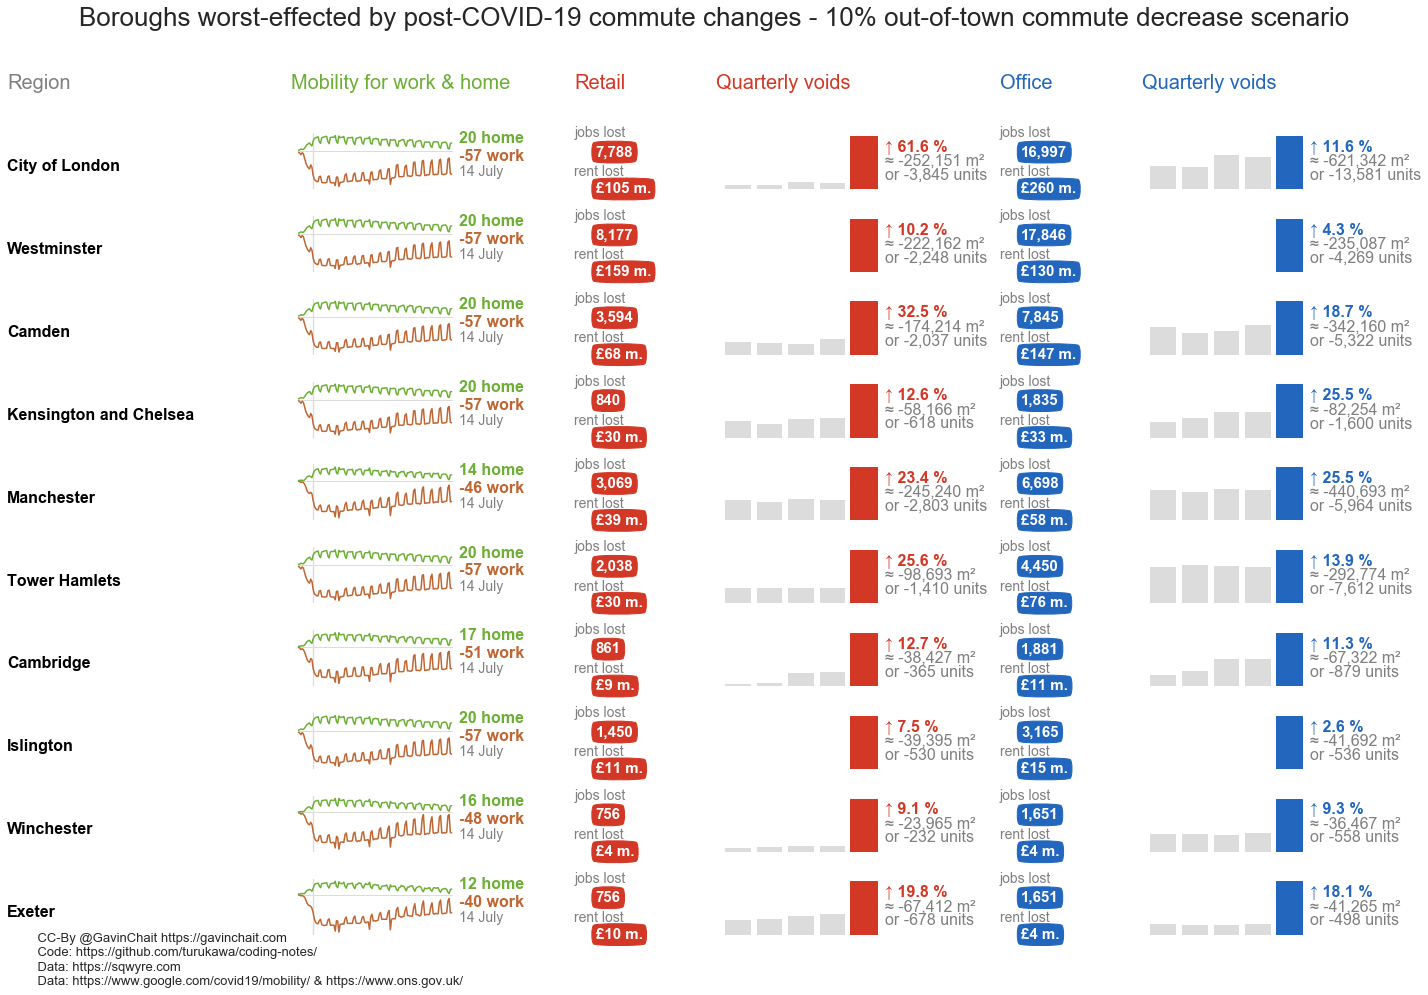

In [6]:
# Losers
title = "Boroughs worst-effected by post-COVID-19 commute changes - 10% out-of-town commute decrease scenario"
create_chart(df.copy(), dfm.copy(), losers, title)

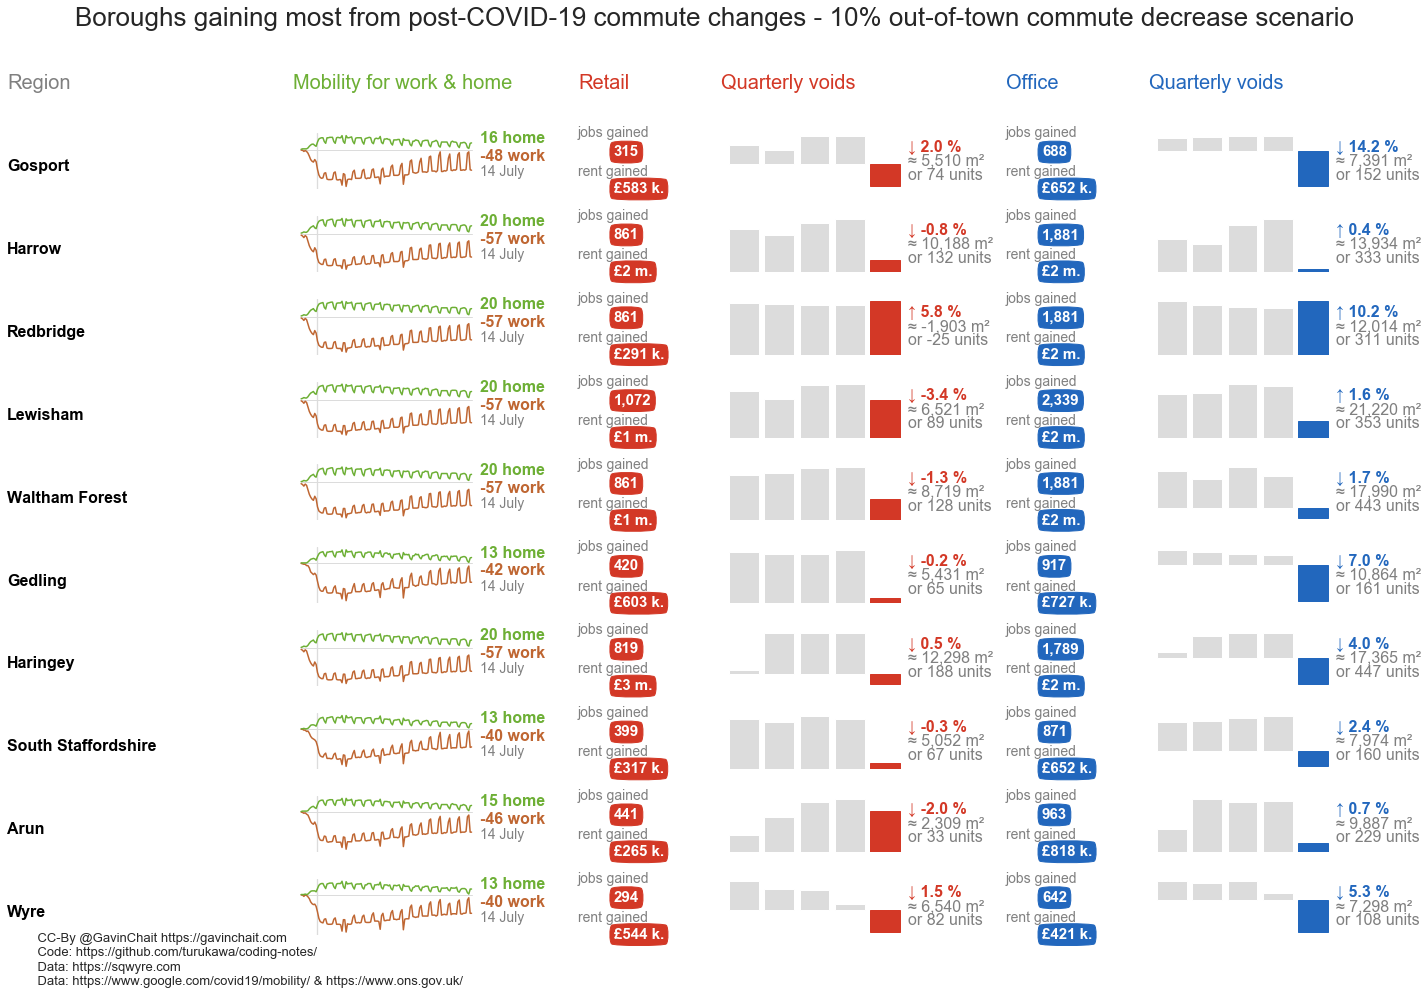

In [7]:
# Winners
title = "Boroughs gaining most from post-COVID-19 commute changes - 10% out-of-town commute decrease scenario"
create_chart(df.copy(), dfm.copy(), winners, title)

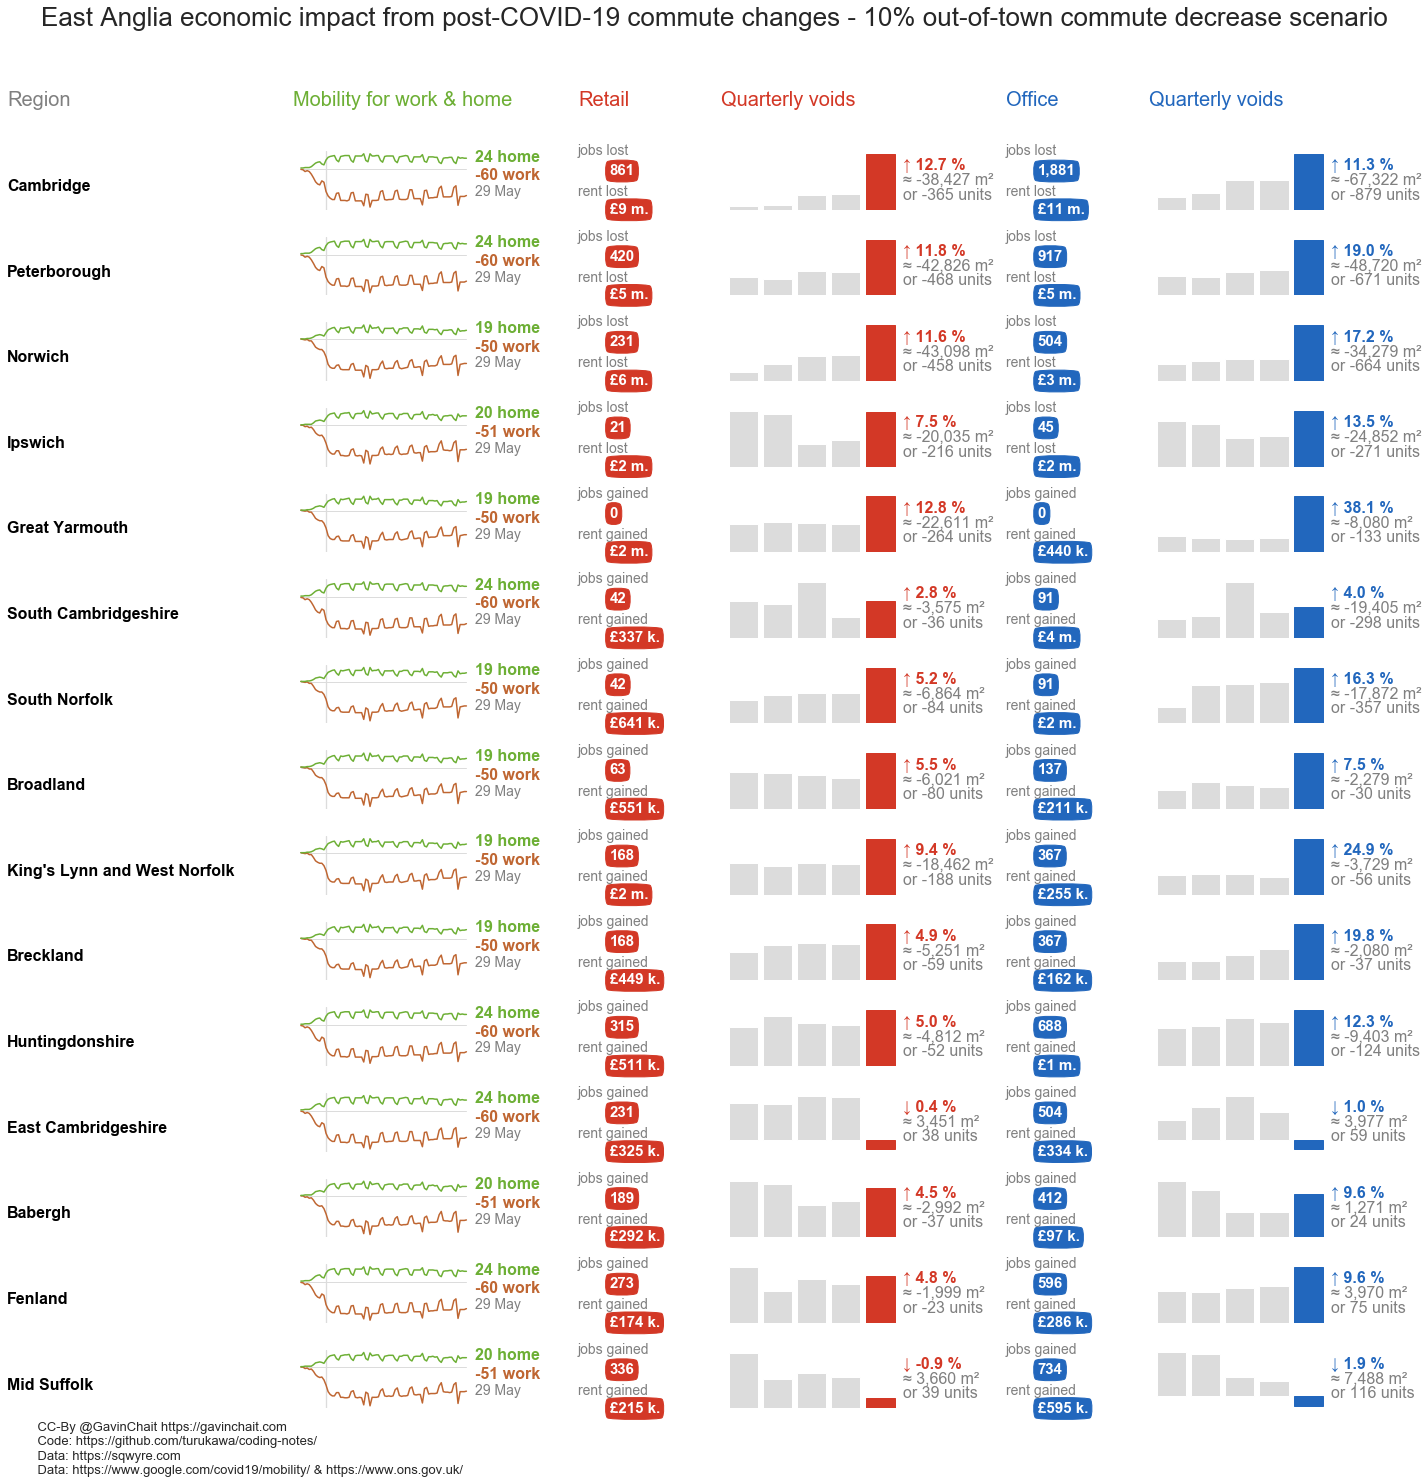

In [8]:
# East Anglia 
title = "East Anglia economic impact from post-COVID-19 commute changes - 10% out-of-town commute decrease scenario"
create_chart(df.copy(), dfm.copy(), suffolk, title, figsize=(20,21))